In [32]:
import osmnx as ox
import folium
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [96]:
def extract_munich_graph():
    # Define the place
    place = "Munich, Germany"

    # Extract the graph for the specified place
    graph = ox.graph_from_place(place, network_type='all')

    # Save the graph to a file or process it further
    # For example, to save as GraphML
    ox.save_graphml(graph, filepath="data/munich_street_network.graphml")

    return graph

def extract_closeup_munich_graph(bbox):
    graph = ox.graph_from_bbox(bbox[0], bbox[2], bbox[1], bbox[3], network_type='drive', simplify=True)
    ox.save_graphml(graph, filepath="data/munich_closeup_street_network.graphml")
    return graph

def read_munich_map():
    graph = ox.load_graphml("../data/munich_street_network.graphml")
    return graph

# Extract and process the graph
# munich_graph = read_munich_map()

bbox = [48.178301, 11.479089, 48.126705, 11.585432]

munich_graph = extract_closeup_munich_graph(bbox)
print("Number of nodes:", munich_graph.number_of_nodes())
print("Number of edges:", munich_graph.number_of_edges())

Number of nodes: 3010
Number of edges: 7419


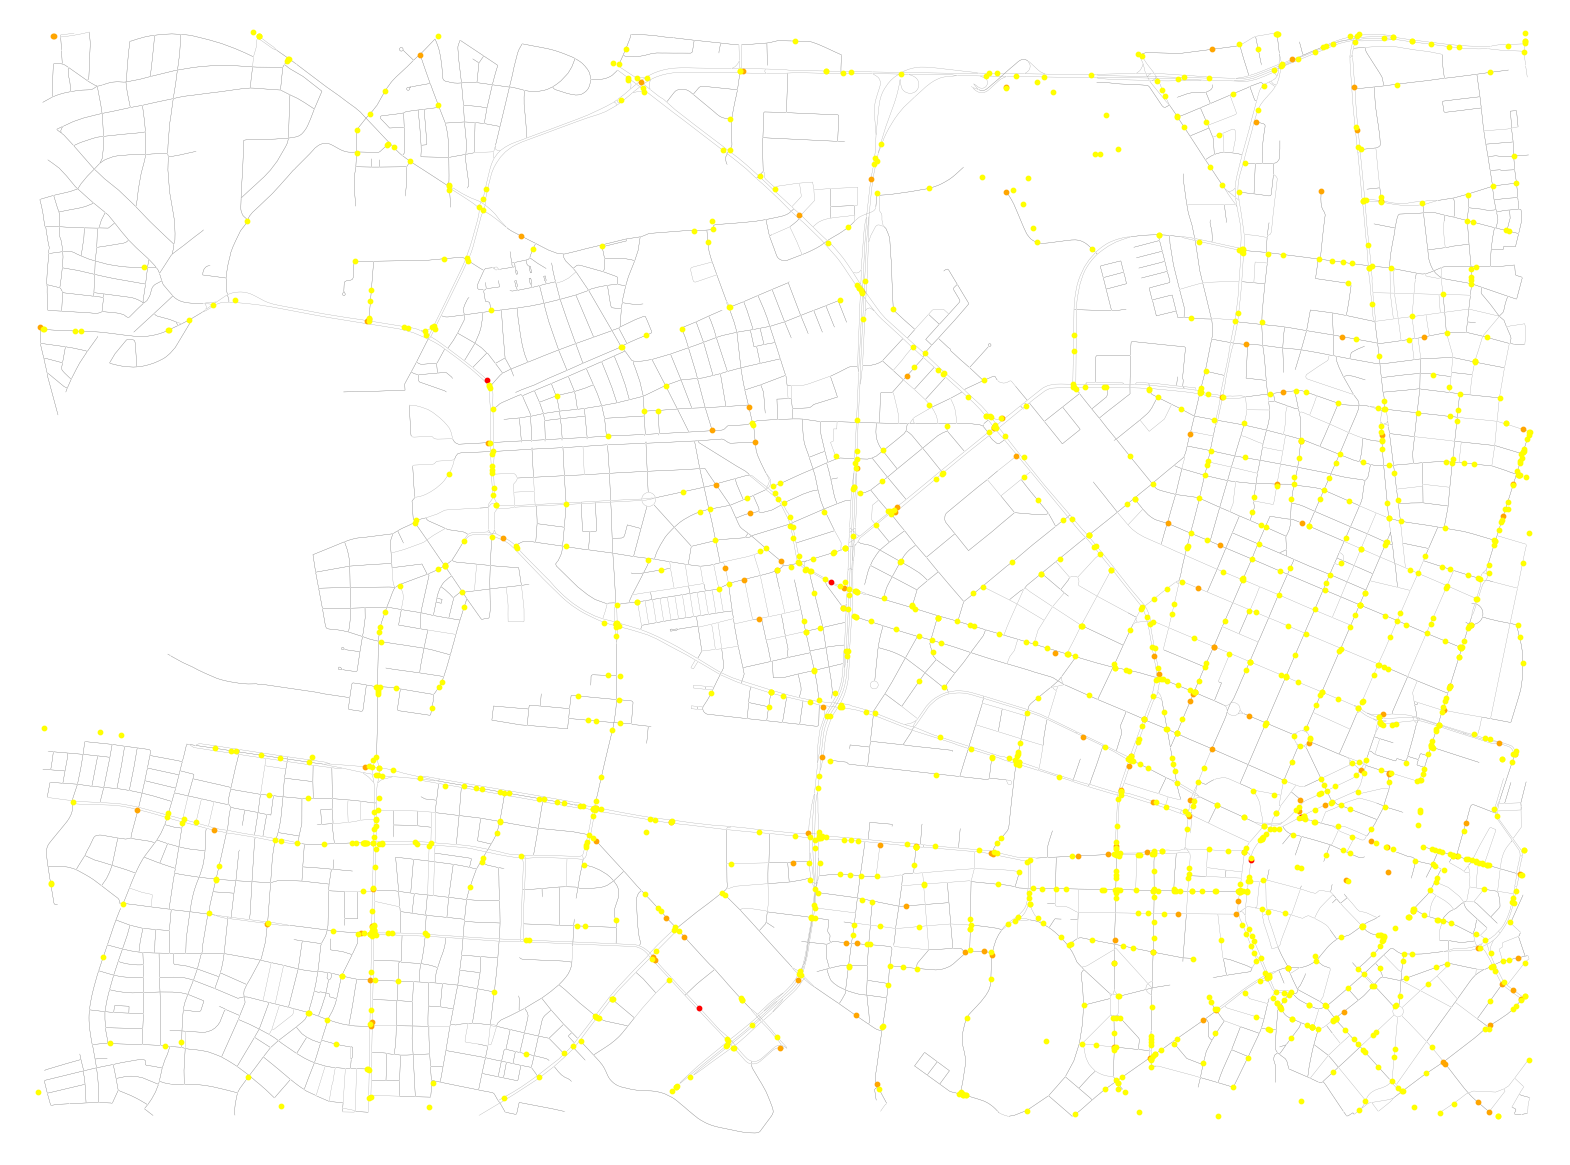

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig, ax = ox.plot.plot_graph(munich_graph, node_size=0.4, edge_linewidth=0.2,ax = ax, show=False, close=False)

color_map = ['red','orange','yellow']




#plot point of interest
for index, row in accident_coords.iterrows():
    ax.scatter(row['XGCSWGS84'],row['YGCSWGS84'], c=color_map[int(row['UKATEGORIE'])-1], s=10,zorder=3)


In [21]:
import osmnx as ox
import folium

def plot_munich_graph(graph):
    # Convert the graph to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(graph)

    # Create a map centered around Munich
    munich_map = folium.Map(location=[48.137154, 11.576124], zoom_start=12)

    # Plot each node on the map
    for idx, row in nodes.iterrows():
        folium.CircleMarker(location=[row['y'], row['x']], radius=2, color='blue').add_to(munich_map)

    # Plot each edge (route) on the map
    # for idx, row in edges.iterrows():
    #     # Define the line geometry, ensure it's a LineString
    #     if row.geometry.geom_type == 'LineString':
    #         points = list(row.geometry.coords)
    #     else:  # it's a MultiLineString
    #         points = list(row.geometry[0].coords)

    #     # Convert coordinates to a format folium understands
    #     folium_line = [(point[1], point[0]) for point in points]
        
    #     # Add the line to the map
    #     folium.PolyLine(folium_line, color="red", weight=2).add_to(munich_map)

    return munich_map

# Extract the graph for Munich
place = "Munich, Germany"

# Create the map with nodes and routes
munich_map = plot_munich_graph(munich_graph)

# To display the map in a Jupyter notebook, you would use
munich_map


In [98]:
def assign_accidents_to_nodes(graph, accident_coords,dist_inter=10):
    # Initialize all nodes with 'num_accidents' attribute set to 0
    for node in graph.nodes:
        graph.nodes[node]['num_accidents'] = 0

    for edge in graph.edges:
        graph.edges[edge]['num_accidents'] = 0

    for index, row in accident_coords.iterrows():
        # Find the nearest node to each accident coordinate
        x_acc = row['XGCSWGS84'] ; y_acc = row['YGCSWGS84']
        nearest_node,dist = ox.nearest_nodes(graph, X=x_acc, Y=y_acc,return_dist=True)

        if dist < dist_inter:
            # Increment the accident count for this node
            graph.nodes[nearest_node]['num_accidents'] += 1
        
        else:
            nearest_edge = ox.nearest_edges(graph, X=x_acc, Y=y_acc)
            graph.edges[nearest_edge]['num_accidents'] += 1

    return graph


# Assign the accident counts to the nodes
munich_graph_accident = assign_accidents_to_nodes(munich_graph, accident_coords, dist_inter=10)
# munich_graph_accident_5 = assign_accidents_to_nodes(munich_graph, accident_coords, dist_inter=5)


88.5892702866598
1.5746810943672598
1.0279529851457758
3.208824210372387
0.7046354717064416
8.929154151132431
1.1977582911632507
46.390160385028196
42.33837507379813
110.54341957054798
12.22390447414421
4.250754129162483
6.605812030855189


In [119]:
ox.save_graphml(munich_graph_accident, filepath="data/munich_street_network_accident.graphml")

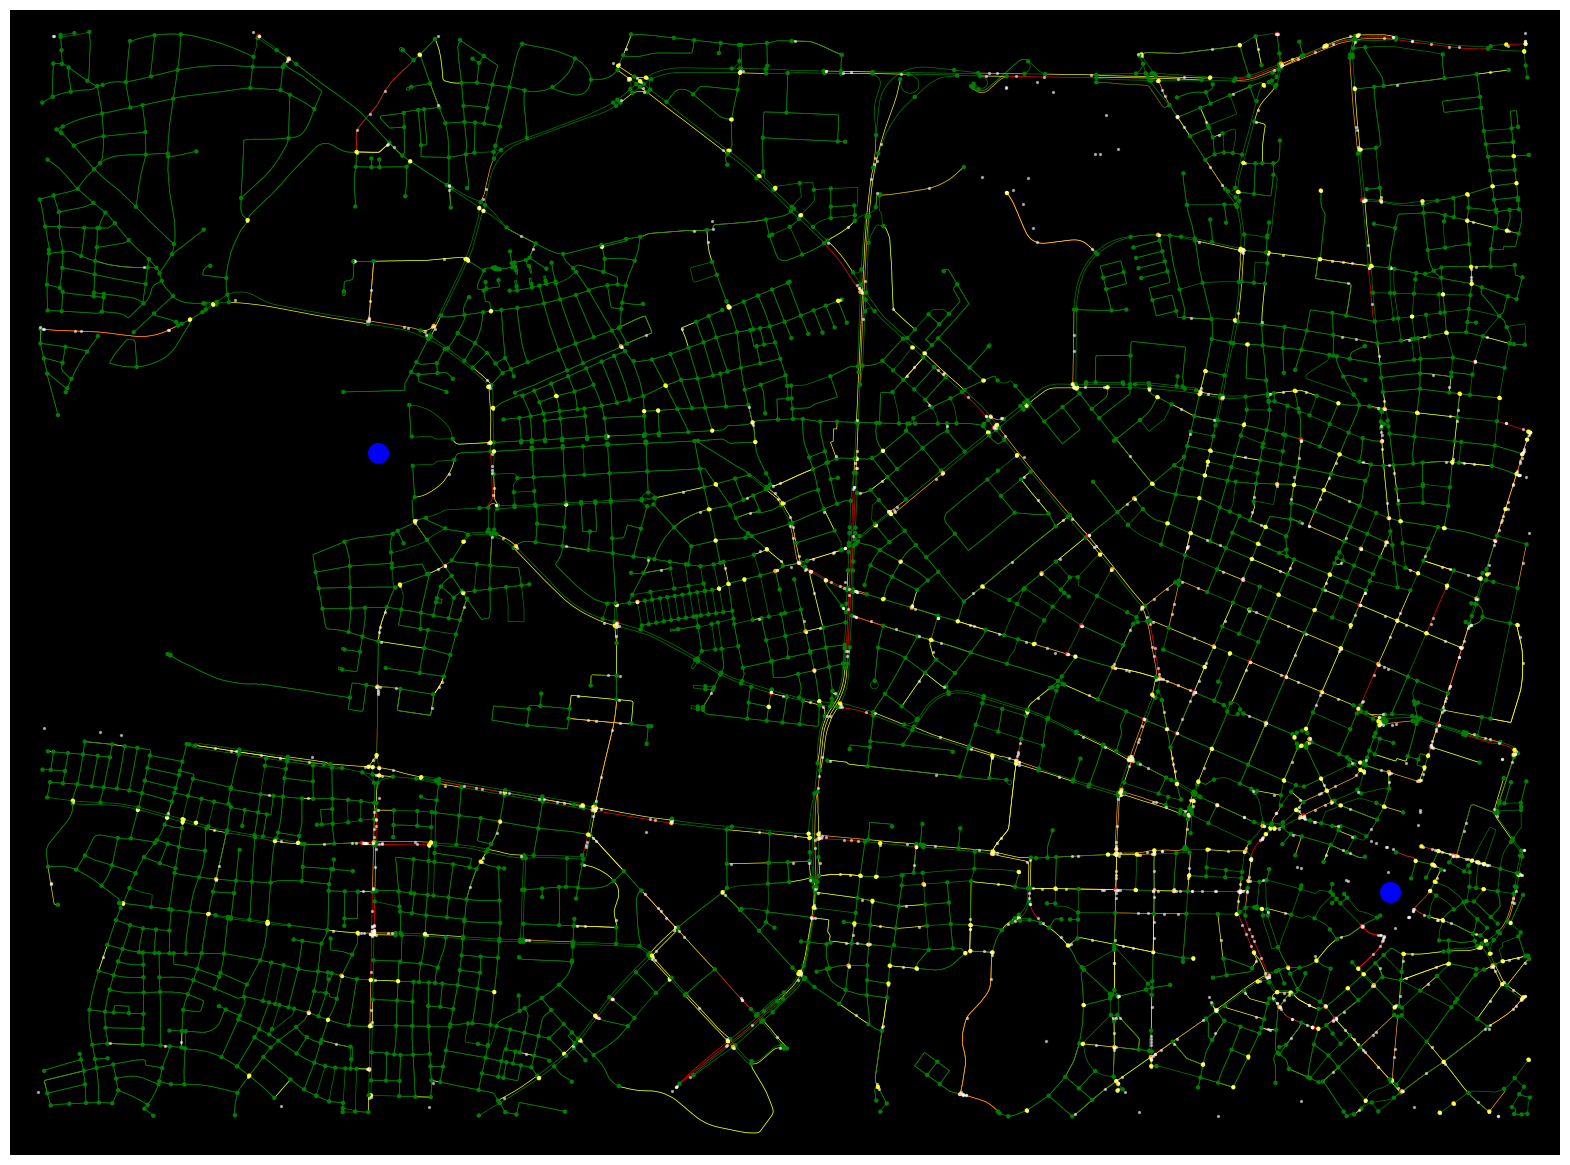

In [113]:
def get_colors_by_accidents(graph):
    node_colors = []
    edge_colors = []
    for node, data in graph.nodes(data=True):
        num_accidents = data.get('num_accidents', 0)
        if num_accidents == 0:
            color = 'green'  # No accidents
        elif num_accidents <= 1:
            color = 'yellow'  # Few accidents
        elif num_accidents <= 2:
            color = 'orange'  # Moderate accidents
        else:
            color = 'red'  # Many accidents
        node_colors.append(color)
    for u, v, data in graph.edges(data=True):
        num_accidents = data.get('num_accidents', 0)
        if num_accidents == 0:
            color = 'green'
        elif num_accidents <= 1:
            color = 'yellow'
        elif num_accidents <= 2:
            color = 'orange'
        else:
            color = 'red'
        edge_colors.append(color)
    return node_colors, edge_colors
    
# Assuming 'graph' is already processed with accident data
# graph = assign_accidents_to_nodes(graph, accident_coords)

# Get the node colors based on the number of accidents
node_colors, edge_colors = get_colors_by_accidents(munich_graph_accident)

# Plot the graph
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# fig, ax = ox.plot.plot_graph(munich_graph_accident, node_color=node_colors, node_size=0.4, edge_linewidth=0.2,ax = ax, show=False, close=False)

fig, ax = ox.plot_graph(munich_graph_accident, node_color=node_colors, edge_color=edge_colors,figsize=(20, 20), node_size=10, edge_linewidth=0.5, show=False, close=False,bgcolor='black')
ax.scatter(accident_coords['XGCSWGS84'],accident_coords['YGCSWGS84'], c="white", s=2,zorder=3, alpha=0.5)
fig.savefig('munich_accident.png', dpi=300)

# Plot departure and arrival points
marienplatz = (48.137393, 11.575448)
nympenburg = (48.158268,11.503314)
ax.scatter(marienplatz[1],marienplatz[0], c="blue", s=200,zorder=3)
ax.scatter(nympenburg[1],nympenburg[0], c="blue", s=200,zorder=3)



In [ ]:
def number_of_accidents(route):
    num_accidents = 0
    for node in route:
        num_accidents += munich_graph_accident.nodes[node]['num_accidents']
    return num_accidents


In [25]:
accident_coords = [
    (49.1351, 12.5820),  # Example coordinate 1
    (48.1386, 11.5845),  # Example coordinate 2
    # ... more coordinates
]

# Assign accidents to nodes
assigned_nodes = assign_accidents_to_nodes(graph, accident_coords)
add_accident_attributes_to_nodes(graph, assigned_nodes)
munich_map_with_accidents = plot_graph_with_accidents(graph)

In [118]:
from openrouteservice import client

api_key = '5b3ce3597851110001cf6248bef01ef5bac84751865f2ee2c21dcf5c'  # Individual api key
ors = client.Client(key=api_key)  # Create client with api key

centerpoint = ((marienplatz[0]+nympenburg[0])/2,(marienplatz[1]+nympenburg[1])/2)

map_params = {'tiles': 'OpenStreetMap',
              'location': centerpoint,
              'zoom_start': 13.5}



map = folium.Map(**map_params)
route, summary = driving_directions(ors, marienplatz, nympenburg)
